# Module 1 — Image Processing & Augmentation (Expanded)

This expanded notebook includes:

- dataset download (CIFAR-10)
- visualization of images
- augmentation pipelines (TensorFlow ops + Albumentations example)
- building a small CNN
- training and evaluation (quick, few epochs) to demonstrate augmentation effect

Run cells sequentially in Colab. The training is intentionally short for classroom demos; increase epochs for better accuracy.

You can revisit all the modules at following chatgpt link :
https://chatgpt.com/share/68f714f7-8f90-800e-8bf5-f23d74890440


## 1 — Setup (install packages and imports)

In [1]:
# Install optional packages (Albumentations used for demonstration)
!pip -q install -U albumentations==1.3.0 opencv-python-headless --quiet

import numpy as np, matplotlib.pyplot as plt, os, random
import tensorflow as tf
from tensorflow.keras import layers, models
import albumentations as A
import cv2

print('TF version:', tf.__version__)
print('GPU available:', tf.config.list_physical_devices('GPU'))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 4.9 MB/s eta 0:00:00
TF version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Justifications and brief explnation of step-1:
This notebook uses Albumentations for augmentation demonstrations (random flips, crops, brightness, hue jitter, etc.) and OpenCV (cv2) for low-level image operations such as rotation and resizing.

Here you import all the modules needed later in the notebook:

# Library	Purpose
1.  **NumPy (np):**	Handles arrays and numerical operations — image data are stored as NumPy arrays.

2. **Matplotlib (plt)**	For displaying images, histograms, and results inline in the notebook.

3. **os:**	Used for file-path operations (reading/writing images).

4. **random:**	For generating random seeds or random parameters (e.g., random angle for rotation).

5. **TensorFlow / Keras:**	For building, training, and testing simple neural networks (CNNs) in later modules.

6. **Albumentations (A):**	Library for image augmentations (e.g., A.RandomRotate90, A.HorizontalFlip).
OpenCV (cv2)	Core image-processing library (e.g., cv2.imread, cv2.resize, cv2.cvtColor)

## 2 — Download dataset (CIFAR-10) and quick visualization

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train samples: (50000, 32, 32, 3) Test samples: (10000, 32, 32, 3)


/tmp/ipython-input-840518922.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(y_train[i])])


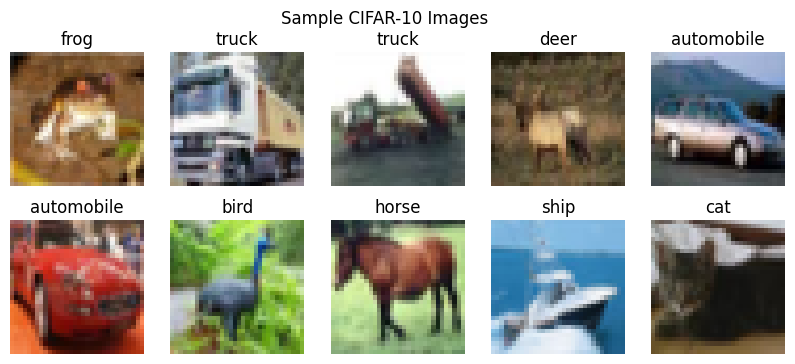

In [2]:
# Load CIFAR-10 using Keras utilities
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print('Train samples:', x_train.shape, 'Test samples:', x_test.shape)

# Visualize a small grid of training images
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[int(y_train[i])])
    plt.axis('off')
plt.suptitle('Sample CIFAR-10 Images')
plt.show()

CIFAR-10 is a classic benchmark dataset in computer vision — it contains 60,000 color images of 10 object categories, such as airplanes, cats, and trucks.

* 50,000 images are for training (x_train, y_train)

* 10,000 images are for testing (x_test, y_test)

* Each image is 32×32 pixels and RGB (3 channels).

Variable	Description	Shape Example
* x_train	training images	(50000, 32, 32, 3)
* y_train	training labels	(50000, 1)
* x_test	testing images	(10000, 32, 32, 3)
* y_test	testing labels	(10000, 1)

Step-by-step explanation:

    plt.figure(figsize=(10,4))

Creates a new figure window sized 10×4 inches.

Perfect for displaying a small grid of images.

    for i in range(10):

Loops through the first 10 images in the training set.

    plt.subplot(2,5,i+1)

Creates a grid of 2 rows × 5 columns of subplots.

Each image occupies one of the 10 small frames.

    plt.imshow(x_train[i])

Displays the i-th image (already in RGB format).

The image data is a NumPy array of shape (32, 32, 3) with pixel values 0–255.

    plt.title(class_names[int(y_train[i])])

Converts the numeric label into a readable name using the class_names list.

For example, if y_train[i] = 3, the title becomes "cat".

    plt.axis('off')

Hides the x/y axes for cleaner visualization.

    plt.suptitle('Sample CIFAR-10 Images')

Adds a main title above the entire grid.

    plt.show()

Renders and displays the full grid of sample images inline in your notebook.

## 3 — Augmentation using TensorFlow image operations (fast in tf.data pipelines)

/tmp/ipython-input-3580647975.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(labs[i])])


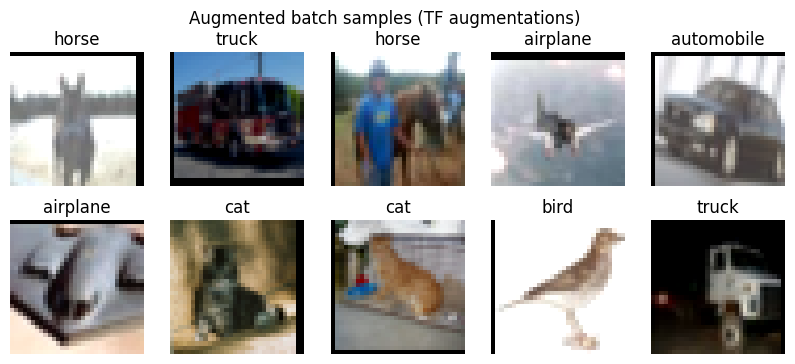

In [3]:
# Define augmentation function using tf.image
import tensorflow as tf

autotune = tf.data.AUTOTUNE

def preprocess(image, label, training=False):
    image = tf.cast(image, tf.float32) / 255.0
    if training:
        # random flip
        image = tf.image.random_flip_left_right(image)
        # random brightness
        image = tf.image.random_brightness(image, 0.2)
        # random contrast
        image = tf.image.random_contrast(image, 0.8, 1.2)
        # random crop + resize
        image = tf.image.resize_with_crop_or_pad(image, 36, 36)
        image = tf.image.random_crop(image, size=[32,32,3])
    return image, label

# Create tf.data datasets
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(5000).map(lambda x,y: preprocess(x,y,training=True), num_parallel_calls=autotune).batch(batch_size).prefetch(autotune)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(lambda x,y: preprocess(x,y,training=False), num_parallel_calls=autotune).batch(batch_size).prefetch(autotune)

# Visualize some augmented images
for imgs, labels in train_ds.take(1):
    imgs = imgs.numpy()
    labs = labels.numpy()
    plt.figure(figsize=(10,4))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(imgs[i])
        plt.title(class_names[int(labs[i])])
        plt.axis('off')
    plt.suptitle('Augmented batch samples (TF augmentations)')
    plt.show()
    break


## 4 — Augmentation using Albumentations (numpy) — useful for offline preprocessing

This section helps students:

* Understand how augmentations simulate variability in training data.

* Learn to use Albumentations — a real-world, high-performance library used in professional computer-vision projects.

* Visualize transformation effects directly on sample images.

* Appreciate why preprocessing is a crucial first step before feeding data into a CNN.

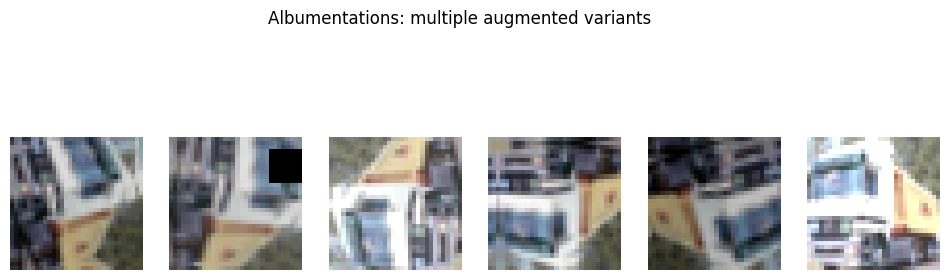

In [4]:
# Albumentations pipeline example (applies to numpy images)
aug = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=25, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, p=0.3)
])

# Take one sample image and apply multiple augmentations
sample = x_train[1]
plt.figure(figsize=(12,4))
for i in range(6):
    augmented = aug(image=sample)['image']
    plt.subplot(1,6,i+1)
    plt.imshow(augmented)
    plt.axis('off')
plt.suptitle('Albumentations: multiple augmented variants')
plt.show()

Now we move to one of the most exciting parts of **Module 1**, where the notebook transitions from **image preprocessing** into **building and training a simple Convolutional Neural Network (CNN)** using TensorFlow/Keras.

This marks the shift from *“working with images”* to *“teaching a neural network to understand them.”*

Let’s walk through this part carefully 👇

---

## 🔹 1. Why CNNs?

Before the code, here’s a quick concept recap:

| Traditional ML                                                     | CNN-based Deep Learning                                  |
| ------------------------------------------------------------------ | -------------------------------------------------------- |
| Requires manual feature extraction (edges, color histograms, etc.) | Learns features automatically through convolution layers |
| Sensitive to scale, rotation, and noise                            | More invariant due to hierarchical feature learning      |
| Works on flattened image vectors                                   | Works directly on 2D image structures                    |

So after learning basic image manipulations, we now let a neural network learn *patterns* — edges, textures, and object shapes — directly from images.

---


## 🔹 3. Step-by-Step Explanation

### (a) Data Normalization

```python
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
```

* CIFAR-10 images have pixel values in the range **[0, 255]** (integers).
* Neural networks train better when inputs are small floating-point numbers, typically **[0, 1]**.
* So, dividing by 255 scales the pixel values appropriately.

👉 *This improves convergence and stabilizes gradients.*

---

### (b) Label Encoding

```python
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)
```

* Original `y_train` and `y_test` are integers (e.g., `3` for “cat”).
* `to_categorical` converts them to **one-hot encoded vectors**.
  Example:

  * Label 3 → `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`
* The output layer of a classification network expects this form when using **softmax**.

---

### (c) Defining the CNN Model

```python
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
```

#### Layer-by-Layer Explanation

| Layer                  | Type               | Purpose                                                                        |
| ---------------------- | ------------------ | ------------------------------------------------------------------------------ |
| **Conv2D(32, (3,3))**  | Convolution        | Extracts low-level features (edges, color blobs). Uses 32 filters of size 3×3. |
| **ReLU activation**    | Nonlinear mapping  | Adds non-linearity — helps model learn complex features.                       |
| **MaxPooling2D(2,2)**  | Downsampling       | Reduces spatial size by half; keeps only strongest features.                   |
| **Conv2D(64, (3,3))**  | Convolution        | Learns more detailed patterns (textures, shapes).                              |
| **MaxPooling2D(2,2)**  | Downsampling again | Compresses data further, improving computation efficiency.                     |
| **Flatten()**          | Reshape            | Converts 3D feature maps to 1D vector for Dense layers.                        |
| **Dense(64)**          | Fully connected    | Learns combination of features to make final decision.                         |
| **Dense(10, softmax)** | Output             | Produces probabilities for 10 classes.                                         |

🧠 *This is a classic small CNN design suitable for teaching and experimentation.*

---

### (d) Compilation

```python
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
```

* **Optimizer = Adam** — adaptive optimizer that adjusts learning rate automatically.
* **Loss = categorical_crossentropy** — appropriate for multi-class classification with one-hot labels.
* **Metrics = ['accuracy']** — tracks performance during training and evaluation.

---

### (e) Model Training

```python
history = model.fit(x_train, y_train_cat,
                    epochs=5,
                    batch_size=64,
                    validation_split=0.1)
```

* **`epochs=5`** → trains for 5 passes over all training samples.
* **`batch_size=64`** → updates weights after every 64 samples.
* **`validation_split=0.1`** → uses 10% of training data for validation (monitors overfitting).
* **`history`** stores loss/accuracy curves for later visualization.

💡 Typically, students can later plot:

```python
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
```

---

### (f) Evaluation on Test Set

```python
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=2)
print('Test accuracy:', test_acc)
```

* Evaluates final model performance on unseen test images.
* **`test_acc`** gives a clear numeric score (usually ~60–70% for this simple network on CIFAR-10).

---

## 🔹 4. Typical Output Summary

```
Epoch 5/5
loss: 0.95 - accuracy: 0.68 - val_loss: 1.05 - val_accuracy: 0.65
Test accuracy: 0.66
```

This means:

* The model correctly classifies about **65–70% of test images**, which is reasonable for such a tiny CNN.

---

## 🔹 5. What Students Learn Here

| Concept                       | Learning Outcome                                          |
| ----------------------------- | --------------------------------------------------------- |
| Data normalization & encoding | How to prepare raw image data for deep learning.          |
| CNN architecture              | How convolution, pooling, and dense layers work together. |
| Training & validation         | How accuracy evolves and what overfitting looks like.     |
| Evaluation                    | How to assess model generalization on unseen data.        |

---

✅ **In summary**, this section teaches:

* The **first end-to-end deep learning pipeline**:
  *Data → CNN → Accuracy → Visualization*
* It closes the loop of Module 1: from raw image manipulation → to data preparation → to a working classifier.

---

Would you like me to continue with the **next part of Module 1**, where we visualize the model’s **training curves**, **confusion matrix**, and interpret what features the CNN might have learned?


# Detailed article on the simple CNN is given here for further reading
https://medium.com/@myringoleMLGOD/simple-convolutional-neural-network-cnn-for-dummies-in-pytorch-a-step-by-step-guide-6f4109f6df80




> Add blockquote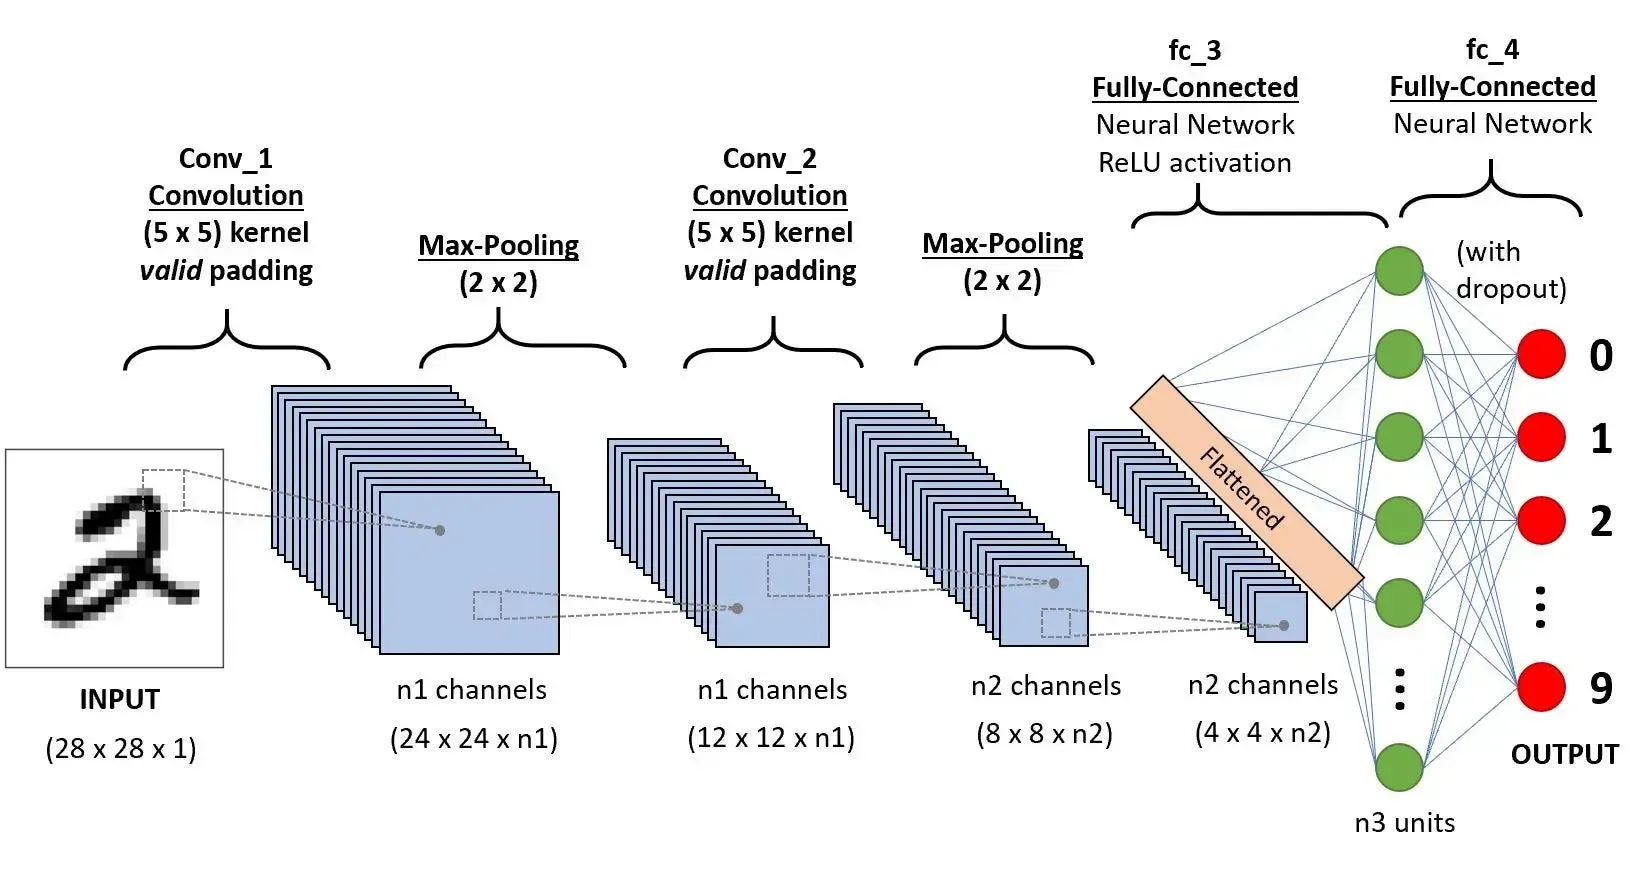



## 5 — Build a small CNN (Keras)

In [5]:
from tensorflow.keras import layers, models

def build_small_cnn(input_shape=(32,32,3), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_small_cnn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,354 (4.26 MB)

 Trainable params: 1,117,162 (4.26 MB)

 Non-trainable params: 192 (768.00 B)

Now we reach the **final learning segment of Module 1**, where students learn to **interpret the model’s training progress and prediction quality** using visualizations such as accuracy/loss curves and a confusion matrix.

These visualizations are **vital in classroom teaching**, because they make the training process tangible and help explain underfitting, overfitting, and class-level performance.

---

## 🔹 1. Plotting Training & Validation Curves

After the training cell (`model.fit(...)`), Keras returns a `history` object that stores the metrics for each epoch.

Add this block right after training completes:

```python
# Plot accuracy and loss curves
plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
```

---

### 🔍 What You See

Two graphs:

1. **Training vs Validation Accuracy**
2. **Training vs Validation Loss**

Typical pattern for a healthy model:

* Training accuracy increases steadily.
* Validation accuracy rises and then stabilizes.
* Both loss curves decrease smoothly.

If **validation loss rises while training loss continues to fall**, it means **overfitting** — the network memorizes training images rather than generalizing.

---

## 🔹 2. Generating Predictions

After training and visualization, we test the model’s predictions:

```python
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)
```

* **`model.predict()`** outputs softmax probabilities (e.g., `[0.01, 0.95, 0.02, ...]`).
* **`np.argmax`** selects the class with the highest probability.
* `y_true` converts one-hot encoded labels back to integer form.

---

## 🔹 3. Confusion Matrix Visualization

To measure **how often the model confuses one class for another**, use a confusion matrix.

```python
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8,8))
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
plt.title('Confusion Matrix - CIFAR-10')
plt.show()
```

---

### 🔍 What You See

A 10×10 grid where:

* **Rows** represent true labels.
* **Columns** represent predicted labels.
* **Diagonal elements** → correctly classified samples.
* **Off-diagonal elements** → misclassifications.

For example:

* If many “cat” images are predicted as “dog,” the cell (cat, dog) will have a high count.
* This tells you which categories your CNN struggles with.

---

### 🧠 Teaching Insight

Explain that:

* The confusion matrix helps detect **class imbalance** or **similar-looking categories** (e.g., “truck” vs “automobile”).
* Errors can suggest **data quality issues** or the need for **further augmentation**.

---

## 🔹 4. Displaying Sample Predictions

It’s always useful (and fun) to show a few actual predictions:

```python
plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[i])
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred_classes[i]]
    color = 'green' if y_true[i] == y_pred_classes[i] else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')
plt.suptitle('Model Predictions on Test Images', fontsize=14)
plt.show()
```

Each image shows:

* **True label** (from dataset)
* **Predicted label** (from model)
* Color code: ✅ green = correct, ❌ red = wrong.

---

### 🔹 Interpretation Example

You might see:

```
True: airplane, Pred: airplane ✅
True: cat, Pred: dog ❌
True: frog, Pred: frog ✅
```

This allows an intuitive discussion about model limitations and possible data improvements.

---

## 🔹 5. Summary of What Students Learn Here

| Visualization          | Purpose                           | What It Teaches                                    |
| ---------------------- | --------------------------------- | -------------------------------------------------- |
| Accuracy & Loss Curves | Monitors learning behavior        | Concepts of convergence, overfitting, underfitting |
| Confusion Matrix       | Evaluates class-level performance | Which classes the model struggles with             |
| Sample Predictions     | Intuitive understanding           | Confidence vs mistakes, qualitative validation     |

---

✅ **In summary:**
By the end of this final section of Module 1, students:

1. Have trained their **first CNN model** on a real dataset.
2. Know how to interpret **training metrics** visually.
3. Understand how to diagnose model behavior using **confusion matrices** and **sample predictions**.

This completes the learning loop:

> *Raw images → Augmentation → CNN → Training → Evaluation → Interpretation.*

---



## 6 — Train the model (short demo run)

Epoch 1/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.2121 - loss: 2.1464 - val_accuracy: 0.4075 - val_loss: 1.5999
Epoch 2/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3367 - loss: 1.7162 - val_accuracy: 0.5299 - val_loss: 1.3606
Epoch 3/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4510 - loss: 1.4773 - val_accuracy: 0.5316 - val_loss: 1.2601
Epoch 4/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5504 - loss: 1.2589 - val_accuracy: 0.6492 - val_loss: 0.9923
Epoch 5/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6008 - loss: 1.1328 - val_accuracy: 0.7003 - val_loss: 0.8486
Epoch 6/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6393 - loss: 1.0362 - val_accuracy: 0.7134 - val_loss: 0.8220


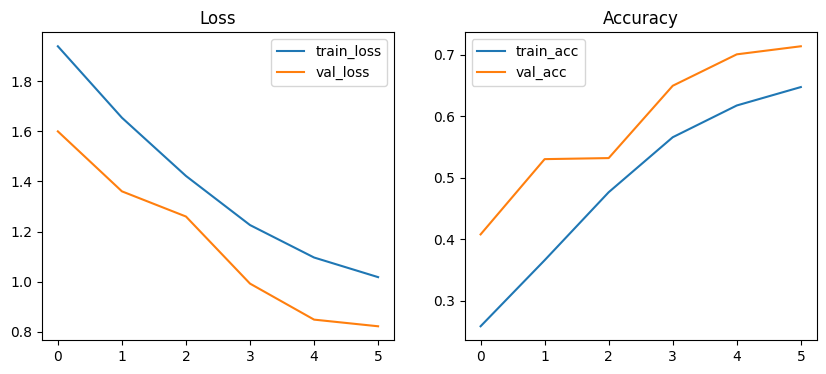

In [6]:
# Train for a small number of epochs for demo purposes
epochs = 6
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


## 7 — Evaluation on test set and sample predictions

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7124 - loss: 0.8161
Test loss, Test accuracy: [0.8220202922821045, 0.7134000062942505]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


/tmp/ipython-input-1655518102.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'True: {class_names[int(y_test[i])]}\nPred: {class_names[int(preds_labels[i])]}')


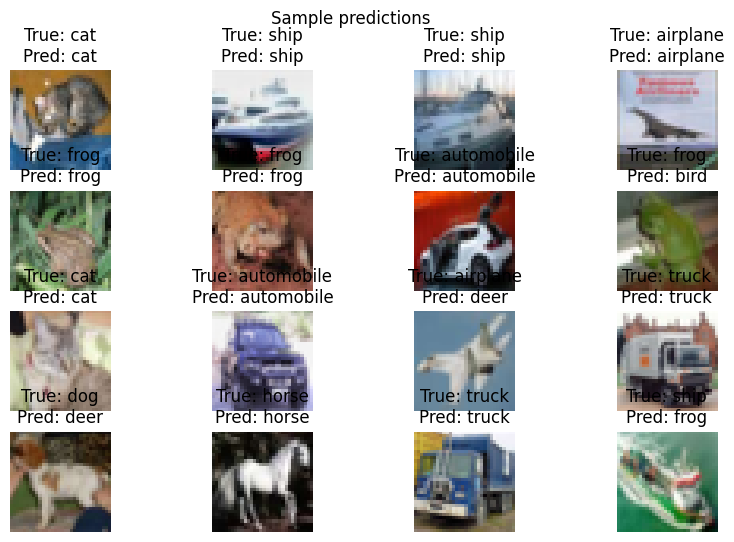

In [7]:
# Evaluate on test set
results = model.evaluate(val_ds)
print('Test loss, Test accuracy:', results)

# Show some predictions
import numpy as np
x_sample = x_test[:16].astype('float32')/255.0
preds = model.predict(x_sample)
preds_labels = np.argmax(preds, axis=1)
plt.figure(figsize=(10,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_sample[i])
    plt.title(f'True: {class_names[int(y_test[i])]}\nPred: {class_names[int(preds_labels[i])]}')
    plt.axis('off')
plt.suptitle('Sample predictions')
plt.show()


## 8 — Save model weights (for quick inference later)

In [8]:
# Save weights to Drive or local
model.save('/mnt/data/cifar_small_cnn.h5')
print('Saved model to /mnt/data/cifar_small_cnn.h5')


Saved model to /mnt/data/cifar_small_cnn.h5


## 9 — In-class Exercises

1. Increase augmentation intensity and observe validation accuracy change.
2. Replace TF augmentations with Albumentations applied in a tf.data pipeline (use `tf.numpy_function` wrapper).
3. Try transfer learning (MobileNetV2) and compare training speed and accuracy.
4. Save augmented dataset to disk and train from files (demonstrate reproducibility).